In [1]:
root_folder = '/media/DATA/jbonato/astro_segm'

In [2]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,root_folder+'/RASTA/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge,art_rem_large,art_rem

from get_traces import update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

# model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


###
MAX_ROI_AREA_PROC=30
MU_PX = 1
DOMAIN_RADIUS = 60
# motion corr in extracting traces
motion_corr=True

In [3]:
#PARAMS
N=256
M=256

fov_list = [2]
fov_DNN_weights_folder = root_folder+'/weights/dense_up' 
set_dir=root_folder+'/set1/'

In [4]:
class SimDataset_test(Dataset):
    def __init__(self,image_set):
        self.input_images = image_set    


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):        
        image = self.input_images[idx]
        image = torch.from_numpy(image).float()

        return image

    
vis_flag = False
##### LOAD PARAM DICT
with open(set_dir+'.tmp/dict_dataset1.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)
max_min = dict_param['max_min']
dict_param

{'list': [0, 40, 80, 120, 160],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5,
 'astro_num': 4,
 'init_th_': 0.6,
 'decr_dim': 10,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'max_min': array([345,  89]),
 'th1_p': 0.25,
 'th2_p': 0.1}

In [29]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
from skimage.feature import register_translation


class Extr_miniROI():
    
    def __init__(self,Area_mu,mu_px,proc_to_split,soma,split_proc=False,dilate_ROI=1):
        
        
        self.Area_mu = Area_mu
        self.mu_px = mu_px
        
        self.Area_px = Area_mu/mu_px**2
        self.proc_to_split = proc_to_split
        self.soma = soma
        self.split_proc = split_proc
        self.dilate_ROI=dilate_ROI
    
    @staticmethod
    def det_conn_comp(processes,soma,dilate_ROI):
        #print(processes.shape)
        N,M = processes.shape
        num,comp = cv2.connectedComponents(processes.astype(np.uint8))
        print('ROIS',num-1)
        processes_out = np.zeros((num-1,N,M))
        for k in range(1,num):
            pt = np.where(comp==k)
            buff = np.zeros((N,M))
            buff[pt[0],pt[1]]=1
            ###dilation
            for _ in range(dilate_ROI):
                element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
                buff = cv2.dilate(buff, element)
            filtered = buff-soma-np.sum(processes_out,axis=0)
            filtered[filtered<1]=0
            processes_out[k-1,:,:]=filtered
            
        return processes_out

    def get_k(self,area):
        return area/self.Area_px
    
    def get_miniROI(self):
        
        self.proc_to_split = self.det_conn_comp(self.proc_to_split,self.soma,self.dilate_ROI)
        #print('check size',self.proc_to_split.shape)
        if self.split_proc :
            Nroi,H,W = self.proc_to_split.shape
            collROI = []
            for i in range(Nroi):
                N = np.sum(self.proc_to_split[i,:,:])
                k = self.get_k(N)
                #print('ratio',k,int(k))
                if int(k)<=1:
                    collROI.append(self.proc_to_split[i,:,:][:,:,np.newaxis])
                else:
                    rr = k.astype(np.int64)
                    buff = np.zeros((H,W,rr))
                    pt = np.where(self.proc_to_split[i,:,:]==1)
                    X = np.asarray([pt[0],pt[1]]).T

                    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(X)
                    labels = kmeans.labels_

                    for j in range(int(k)):
                        pt_lb = np.where(labels==j)
                        buff[X[pt_lb[0],0],X[pt_lb[0],1],j]=1

                    collROI.append(buff)
            out = collROI[0]       

            if len(collROI)>1:
                for i in range(1,len(collROI)):  
                    #print(collROI[i].shape)
                    out = np.dstack((out,collROI[i]))
            print('SPLIT DONE',out.shape)
            return out
        else:
            print('SPLIT DONE',self.proc_to_split.shape)
            out = np.moveaxis(self.proc_to_split,[0,1,2],[2,0,1])
            return out
    
    
    
def get_signals(roi,stack):
    T,_,_ = stack.shape
    _,_,N = roi.shape
    
    signals = []
    for i in range(N-1):
        pt = np.where(roi[:,:,i]==1)
        #ev add single pixels rem
        signals.append(np.mean(stack[:,pt[0],pt[1]],axis=1))
    return signals

def get_signal(roi,stack):
    pt = np.where(roi==1)
    return np.mean(stack[:,pt[0],pt[1]],axis=1)

def allineate_stack(stack,shift,r_domain):
    T,N,M = stack.shape
    stack_out = np.zeros_like(stack)
    stack_pad = np.pad(stack,((0,0),(r_domain,r_domain),(r_domain,r_domain)), 'constant', constant_values=0)
    for t in range(T):
        stack_out[t,:,:]= stack_pad[t,r_domain-shift[t,0]:r_domain+N-shift[t,0],r_domain-shift[t,1]:r_domain+M-shift[t,1]]
    return stack_out

def box(cX,cY,radius,N):
    casex=2
    casey=2
    if cX-radius<0:
        casex=0
    elif cX+radius>N:
        casex=1
    if cY-radius<0:
        casey=0
    elif cY+radius>N:
        casey=1
    #x
    if casex==2:
        c1x=cX-radius
        c2x=cX+radius
    elif casex==0:
        c1x=0
        c2x=2*radius
    else:
        c1x=N-2*radius
        c2x=N
    #y
    if casey==2:
        c1y=cY-radius
        c2y=cY+radius
    elif casey==0:
        c1y=0
        c2y=2*radius
    else:
        c1y=N-2*radius
        c2y=N
    return c1x,c1y,c2x,c2y

def create_bb_coord_domain(soma_mask,radius = 60):
   
    N,M = soma_mask.shape
    soma = np.empty_like(soma_mask)
    soma = soma_mask.copy()
    soma[soma>0.1]=255

    _,thresh = cv2.threshold(np.uint8(soma),127,255,0)

    # find contours in the binary image
    contours, _= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    # loop over the contours
    #list of array with the coordinate
    coord_list_st = []
    coord_list_cell = []
    coord_list_circle = []
    for c in contours:
        if c.shape[0]!=1:
            im_buff = np.zeros((N,M))
            # compute the center of the contour
            M = cv2.moments(c)
            cX = int(M["m10"] / (M["m00"]+1e-5))
            cY = int(M["m01"] / (M["m00"]+1e-5))
            #compute the region of astrocyte radius 60
            c1x,c1y,c2x,c2y = box(cX,cY,48,N)
            coord_list_cell.append([c1x,c1y,c2x,c2y])
            c1x,c1y,c2x,c2y = box(cX,cY,radius,N)
            cv2.circle(im_buff,(cX,cY),radius,(255,0,0),thickness =-1,lineType=8)
            coord_circle = np.where(im_buff==255)
            coord_list_circle.append(coord_circle)

            coord = np.array([c1x,c1y,c2x,c2y])
            coord_list_st.append(coord)
        return coord_list_st,coord_list_circle, coord_list_cell

    
class Motion_Correction():
    """ inputs: 
        - im_stream numpy array of shape TxNxM (N and M can be equal) 
        - ref_image an image numpy array of shape NxM(same dim of im_stream)
        - eventually ref_frame a scalar
        outputs:
        - shift 
        This class return a stream of image of shape TxNxN (numpy array), all the images are corrected with the algorithm 
        Guizar-Sicairos et al., “Efficient subpixel image registration algorithms,”Optics Letters 33, 156-158 (2008).
        
        Obs.
        -This class must be initialized with the pixel precision that are required
        -If ref_image and ref_frame are not given the reference is the first frame
    """
    def __init__(self,pix_precision):
        self.pix_precision = pix_precision
        

    def motion_corr(self,im_stream,ref_image=None,ref_frame=None):
        if (ref_frame != None and ref_image.all() != None):
            raise Exception('ref_frame or ref_image must be None')
                    
        T,cols,rows = im_stream.shape

        if(ref_image.all()!=None):
            pass
        elif(ref_frame!=None):
            ref_image = im_stream[ref_frame,:,:]
        else:
            ref_image = im_stream[0,:,:]

        shift_vec = np.empty((T,2),dtype=np.float64)
        for i in range(T):
            shift_vec[i,:],_,_ = register_translation(ref_image, im_stream[i,:,:],upsample_factor=self.pix_precision)

        X_shift = np.array([np.arange(T),shift_vec[:,1]])
        Y_shift = np.array([np.arange(T),shift_vec[:,0]])
        
        self.X_shift = X_shift
        self.Y_shift = Y_shift
        return shift_vec.astype(np.int64)
    
    def apply_corr(self,im_stream2):
        
        T,cols,rows = im_stream2.shape
        for i in range(T):
            
            M = np.float32([[1,0,self.X_shift[i,1]],[0,1,self.Y_shift[i,0]]])
            im_stream2[i,:,:] = cv2.warpAffine(im_stream2[i,:,:],M,(rows,cols))
        return im_stream2
        
def update_dict_DNN(dict_im,single_astro_roi,fov_num,motion_corr,MAX_ROI_AREA_PROC,MU_PX,MiniROI=False):
    dict_im['Single_cell_mask_'+fov_num] = single_astro_roi
    dict_roi={}
    dict_traces={}
    dict_cell_coord={}
    dict_cell_shift={}
    dict_im['Cell_num_'+fov_num] = single_astro_roi.shape[0]
    
    print("ROI NUM",single_astro_roi.shape[0])
   
    if motion_corr : mc  = Motion_Correction(pix_precision=1)
    
    for s_roi_num in range(single_astro_roi.shape[0]):
        name = str(s_roi_num)
        
        coord_list_st,coord_list_circle, coord_list_cell = create_bb_coord_domain(single_astro_roi[s_roi_num,:,:,1])
        dict_cell_coord['ST_'+f'{name:0>3}'] = coord_list_st[0]
        dict_cell_coord['CIRCLE_'+f'{name:0>3}'] = coord_list_circle[0]
        dict_cell_coord['BB_cell_'+f'{name:0>3}'] = coord_list_cell[0]
        if motion_corr:
            coord_bb = coord_list_cell[0]
#             print('Shift_'+f'{name:0>3}')
            dict_cell_shift['Shift_'+f'{name:0>3}'] = mc.motion_corr(dict_im['t-series_'+fov_num][:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]],\
                           ref_image=np.mean(dict_im['t-series_'+fov_num][:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]],axis=0))
        
            stack_buffer = allineate_stack(dict_im['t-series_'+fov_num],dict_cell_shift['Shift_'+f'{name:0>3}'],r_domain=dict_im['Astro_domain_radius'])
        else:
            stack_buffer = dict_im['t-series_'+fov_num]
            
        print(50*'%','Extracting cell:',s_roi_num)
        constr_split_roi = Extr_miniROI(MAX_ROI_AREA_PROC,MU_PX,single_astro_roi[s_roi_num,:,:,0],single_astro_roi[s_roi_num,:,:,1],MiniROI)
        arr_out_proc = constr_split_roi.get_miniROI()
        if  s_roi_num==0:
            list_out=arr_out_proc
        else:
            print(list_out.shape,arr_out_proc.shape)
            list_out = np.dstack((list_out,arr_out_proc))
       
        dict_roi['Soma_'+f'{name:0>3}'] = np.where(single_astro_roi[s_roi_num,:,:,1]==1)
        dict_traces['Soma_'+f'{name:0>3}'] = get_signal(single_astro_roi[s_roi_num,:,:,1],stack_buffer)
        for proc_num in range(arr_out_proc.shape[2]):
            name_proc = str(proc_num)
            dict_roi['Proc_'+f'{name:0>3}'+'_'+f'{name_proc:0>3}'] = np.where(arr_out_proc[:,:,proc_num]==1)
            dict_traces['Proc_'+f'{name:0>3}'+'_'+f'{name_proc:0>3}']  = get_signal(arr_out_proc[:,:,proc_num],stack_buffer)
        print('Extraction: done')
    
    dict_im['Signals_extr_'+fov_num] = dict_traces
    dict_im['ROI_'+fov_num] = dict_roi
    dict_im['crop_coord_ROI_'+fov_num] = dict_cell_coord
    
    if motion_corr:
        dict_im['shift_ROI_'+fov_num] = None
    else:
        dict_im['shift_ROI_'+fov_num] = dict_cell_coord
        
    #### for Visualization purposes
    list_out = np.dstack((list_out,dict_im['Final_Mask_'+fov_num][:,:,1:]))
    dict_im['Final_Mask_fraction_'+fov_num] = list_out
    
    return dict_im

In [ ]:
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str

    model.load_state_dict(torch.load(fov_DNN_weights_folder+test_folder_str1+'D1.pt'))
    
    #collect stack to analyze
    
    stack_dir = '/media/DATA/jbonato/astro_segm/set1/'+test_folder_str+'/'

    items_stack = os.listdir(stack_dir)

    print(stack_dir + items_stack[0])
    stack = io.imread(stack_dir + items_stack[0]).astype(np.uint16)
    dict_im['t-series_'+test_folder_str1] = stack
    frames,_,_ = stack.shape

    a_reg = sel_active_reg(stack.astype(np.float32),dict_param)
    mask = a_reg.get_mask()
    mask = fix_mask(mask)
    
    #im_list.append([mask,'Active Regions'])
    dict_im['Active Regions_'+test_folder_str1] = mask
    filter_ = filt_im(stack_dir + items_stack[0],mask,dict_param['bb']-2*dict_param['pad'])
    _, image_to_plot = filter_.create_img()
    # for other dataset spatia_pp methods can be called from filter_, outputs are stack filtered and spatial map enhanced  
    #im_list.append([image_to_plot,'Enhanced'])
    dict_im['Enhanced_'+test_folder_str1] = image_to_plot
    coord_l = filter_.get_instances()
    
    assert coord_l!=0, 'Check Active region extraction module'
    
    
    image_stack = np.empty((len(coord_l),dict_param['bb'],dict_param['bb'])) 

    image_stack,filt_imageL = filter_.save_im()#select the padding val 5 is default
    
    
    image_set = image_stack[:,0,:,:]
    image_set = image_set[:,np.newaxis,:,:]

    imageL_set = image_to_plot*filt_imageL
    imageL_set-=np.mean(imageL_set)
    imageL_set= imageL_set[np.newaxis,np.newaxis,:,:]



    model.eval()   # Set model to evaluate mode
    ######################################## Prob Map
    test_datasetL = SimDataset_test(imageL_set)
    test_loader = DataLoader(test_datasetL, batch_size=15, shuffle=False, num_workers=0)

    inputs = next(iter(test_loader))
    inputs = inputs.to(device)
    pred = model(inputs)
    
    pred_mean = pred.data.cpu().numpy()
    del test_datasetL,test_loader, inputs,pred
    
    mean = pred_mean[0]
    maxim = np.amax(mean,axis=0)
    mean[mean<maxim]=0
        
    prob_mapPL,sm_ent = prob_calc(mean[1,:,:],max_min[0],max_min[1])
    
    #im_list.append([prob_mapPL,'Prob. Map'])
    dict_im['Prob. Map PL_'+test_folder_str1] = prob_mapPL
    #im_list.append([sm_ent,'Prob. Map'])
    dict_im['Prob. Map_'+test_folder_str1] = sm_ent
    ########################################## putative single cell
    test_dataset_S = SimDataset_test(image_set)
    test_loader = DataLoader(test_dataset_S, batch_size=15, shuffle=False, num_workers=0)

    
    pred_mean=[]
    for inputs in test_loader:
        inputs = inputs.to(device)

        pred = model(inputs)
        pred_mean.append(pred.data.cpu().numpy())
        del inputs,pred

    torch.cuda.empty_cache()
    
    for j in range(1,len(pred_mean)):
        pred_mean[0]=np.vstack((pred_mean[0],pred_mean[j]))

    prob_map = np.zeros((N,M,2))

    for i in range(len(coord_l)):
        mean= np.zeros((3,dict_param['bb'],dict_param['bb']))
        mean = pred_mean[0][i,:,:,:].copy()
        
        maxim = np.amax(mean,axis=0)
        mean[mean<maxim]=0
        mean[mean>=maxim]=1

        small_soma = small_soma_to_proc(mean[1,:,:],N = int((2/3)*max_min[1])) ####remove too small somata segmentated
        mean[0,:,:]+=small_soma
        mean[1,:,:]-=small_soma
        
        coord = coord_l[i]
        Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
        Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]



    Res_1[:,:,0] -= Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

    ######### can be wrapped
    
    soma_f = common_merge(Res_1[:,:,1],sm_ent)
    Res_1[:,:,1]=soma_f

    #remove possible artifacts
    small_soma = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False)
    Res_1[:,:,1]-=small_soma

    Res_1[:,:,0] = Res_1[:,:,0]-Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

    #remove large region classified as soma Area>500
    Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=int(1.15*max_min[0]))
    if removal<2:
        Res_1-=Res_1_filt[:,:,np.newaxis]

    Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=max_min[0])
    if removal<2:
        Res_1-=Res_1_filt[:,:,np.newaxis]


    #remove processes without soma
    Res_1_filt = art_rem(Res_1[:,:,1],Res_1[:,:,0])
    Res_1*=Res_1_filt[:,:,np.newaxis]
    
    dict_im['Final_Mask_'+test_folder_str1] = Res_1
    print(20*'%')
    #######################################################################################################
    #Visualization of images
    if vis_flag:
        vis = Visdom(port=8097, server="http://localhost",env='inference_plot')
        for key in dict_im.keys():
            if key in ['Active Regions_'+test_folder_str1,'Enhanced_'+test_folder_str1,'Final_Mask_'+test_folder_str1]:
                image = dict_im[key]
                fig, ax = plt.subplots(figsize=(4,4))
                ax.imshow(image)
                ax.axis('off')
                ax.set_title(key)
                vis.matplot(fig)
                plt.close(fig)
    
    #### Extraction
    single_astro_roi = gen_sc_mask(dict_im['Final_Mask_'+test_folder_str1])
    dict_im = update_dict_DNN(dict_im,single_astro_roi,test_folder_str1,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff
Init threshold 330.0
Zones 12
file loading...
check (550, 256, 256)


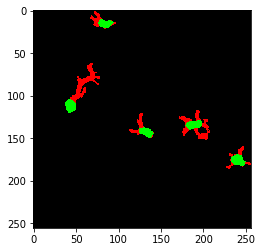

In [14]:
plt.imshow(Res_1)

In [ ]:
dict_im.keys()

# Visualization of results

In [16]:
fov_name = []
for j in fov_list:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

# Manual curation
Export ROIs for ImageJ

In [15]:
from ROI_manual_curation import *

In [17]:
#export ROIs for ImageJ
export_roi(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/')

FOV 002


In [25]:
#clean dictionary from ROIs and extracted traces
dict_im = clean_dict(dict_im,fov_list)

In [26]:
#update dict_im with the manual curated
for fov in fov_list:
    folder = f'{str(fov):0>3}'
    mask_ret = read_roi_curated(folder,N=256,M=256,folder_read='/media/DATA/jbonato/astro_segm/notebook/')
    dict_im = update_dict_DNN(dict_im,mask_ret,folder,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (256, 256, 24)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 4
SPLIT DONE (256, 256, 21)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (256, 256, 11)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 4
SPLIT DONE (256, 256, 9)
Extraction: done


In [18]:
def export_roi2(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/'):
    

    for fov in fov_list:
        
        folder = f'{str(fov):0>3}'
        #if os.path.isfile(folder_save+'ROI_'+folder+'_MC.zip'):
        #    print('Attention: File ',folder_save+'ROI_'+folder+'_MC.zip',' already present')
        #else:
        print('FOV',folder)
        list_roi = []

        for key in dict_im['ROI_'+folder]:
            buff = np.zeros((N,M))
            a,b = dict_im['ROI_'+folder][key]
            buff[a,b]=255

            _,thresh = cv2.threshold(np.uint8(buff),127,255,0)
            # find contours in the binary image
            contours, _= cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
            list_roi.append(contours[0][:,0,:])
            #list_roi.append(ImagejRoi.frompoints(contours[0][:,0,:],name=key))
                
    return list_roi

In [19]:
el = export_roi2(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/')


FOV 002


In [20]:
A = np.zeros((256,256))

In [25]:
for e in el:
    A[e[:,1],e[:,0]]+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


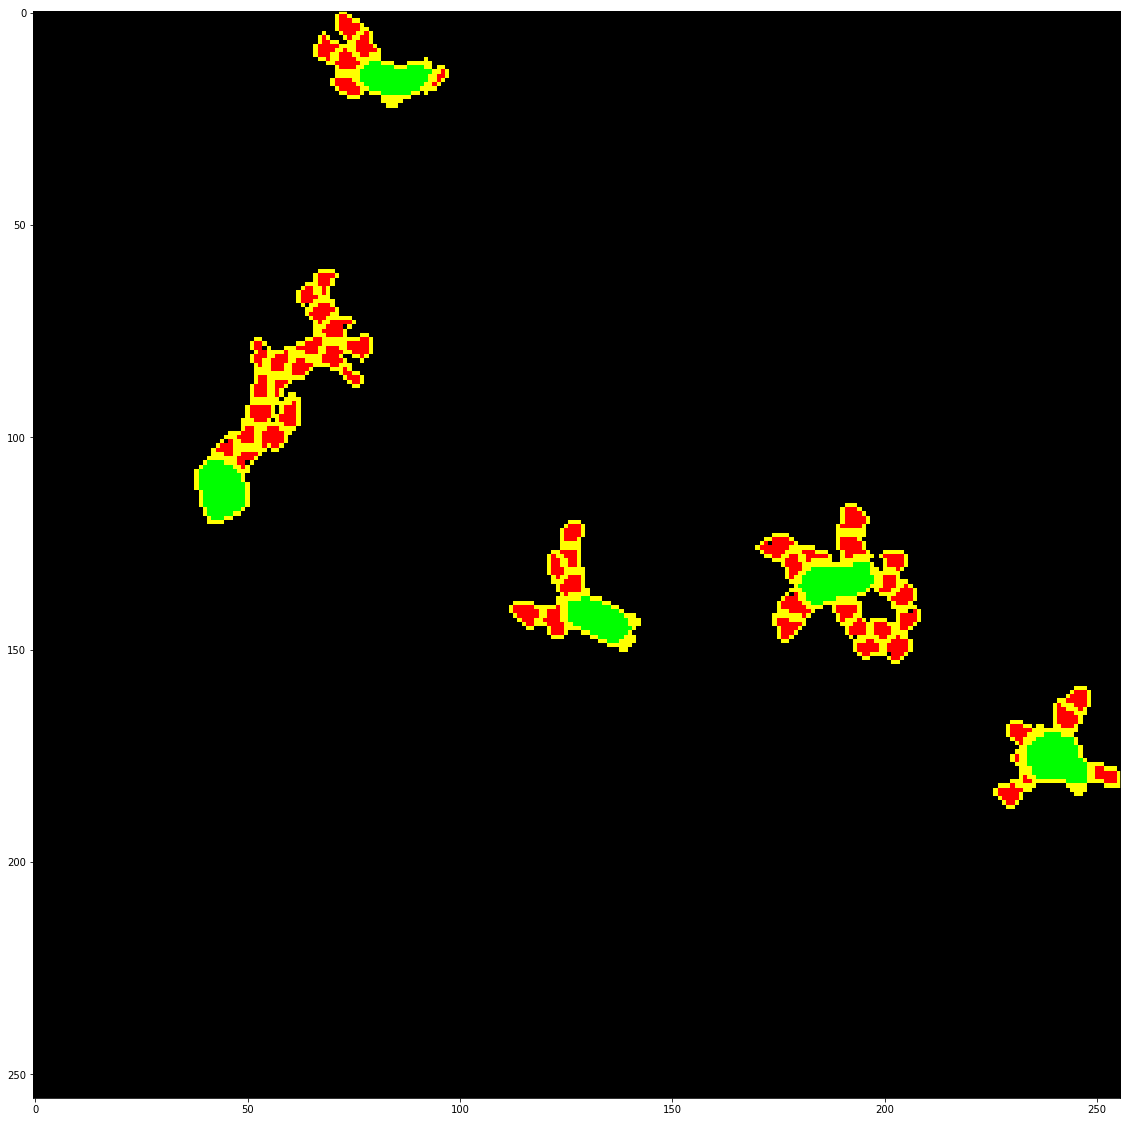

In [26]:
plt.figure(figsize=(20,20))
Res_1[:,:,:2] = Res_1[:,:,:2]+A[:,:,np.newaxis]
plt.imshow(Res_1)